# 0: Import packages & data

In [429]:
# Import packages

# Visualization packages:
library(tidyverse)
library(ggbeeswarm)
library(psych)

# Data pre-processing
library(outliers)
library(EnvStats) # Rosner’s test to identify outlier

# Data manipulation: 
library(dplyr)
library(reshape2)

# Machine Learning
library(randomForest)
library(ROCR)
library(caret)
library(e1071) # Support vector machine
library(xgboost)


Attaching package: 'EnvStats'


The following objects are masked from 'package:e1071':

    kurtosis, skewness


The following objects are masked from 'package:stats':

    predict, predict.lm


The following object is masked from 'package:base':

    print.default




In [1]:
# Set data path
setwd("C:/Users/user/OneDrive - Erasmus University Rotterdam/Documents/01 Postgrad/02 Spring semester/06 Business Analytics for International Managers/rsm_data_analytics")

In [158]:
# Import the CSV file 
df <- read.csv("ebi_customers.csv")
head(df)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0


# 1: Data Pre-Processing

__1.1 Are there any outliers/anomaly in the data that need to be addressed?__

##### 1.1.1 Missing values

In [159]:
missing_values <- sum(is.na(df))
paste0("There are ",  missing_values, " missing values in the dataframe.")

[1] "There are 0 missing values in the dataframe."

##### 1.1.2 Descriptive statistics

In [182]:
# to first check if we have any obvious outliers, we request standard summaries
summary(df)

  credit_score     country             gender               age       
 Min.   :350.0   Length:9000        Length:9000        Min.   :18.00  
 1st Qu.:584.0   Class :character   Class :character   1st Qu.:32.00  
 Median :652.0   Mode  :character   Mode  :character   Median :37.00  
 Mean   :650.4                                         Mean   :38.94  
 3rd Qu.:717.0                                         3rd Qu.:44.00  
 Max.   :850.0                                         Max.   :92.00  
     tenure          balance       products_number  credit_card   
 Min.   : 0.000   Min.   :     0   Min.   :1.000   Min.   :0.000  
 1st Qu.: 3.000   1st Qu.:     0   1st Qu.:1.000   1st Qu.:0.000  
 Median : 5.000   Median : 97263   Median :1.000   Median :1.000  
 Mean   : 5.011   Mean   : 76650   Mean   :1.529   Mean   :0.705  
 3rd Qu.: 7.000   3rd Qu.:127575   3rd Qu.:2.000   3rd Qu.:1.000  
 Max.   :10.000   Max.   :250898   Max.   :4.000   Max.   :1.000  
 active_member    estimated_salary

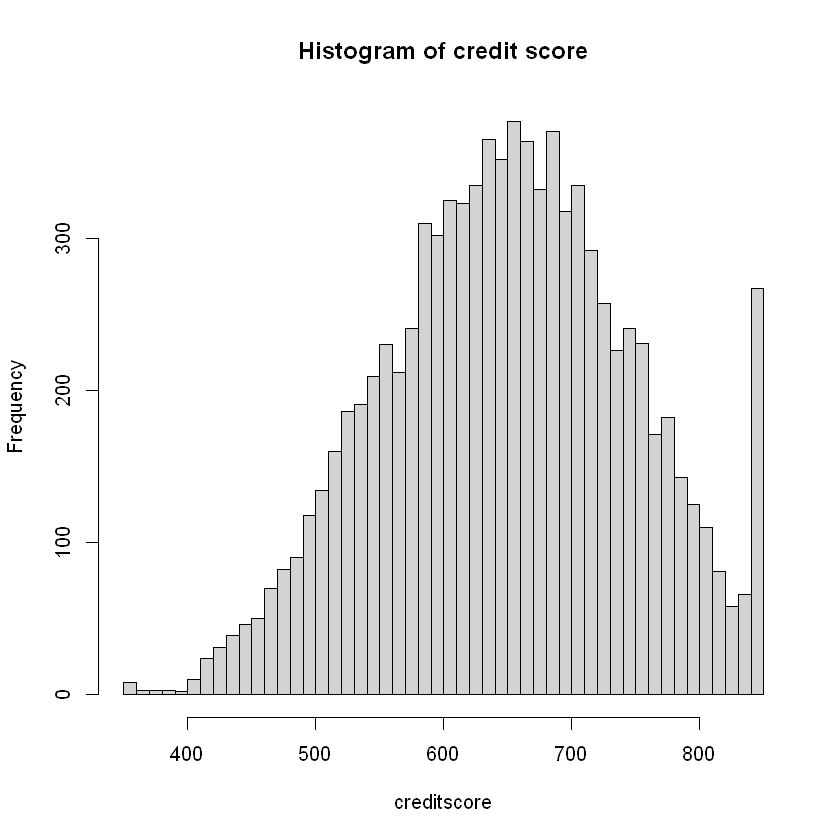

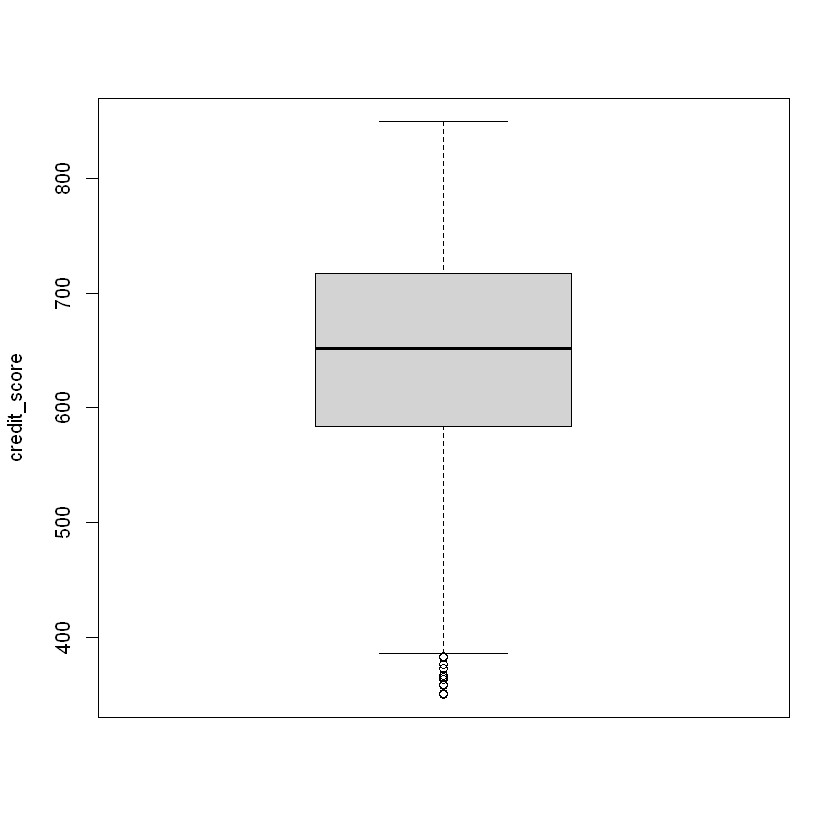

In [192]:
# we then plot histograms and boxplots on the basis of data for more easy visual access
hist(df$credit_score,
     xlab = "creditscore",
     main = "Histogram of credit score",
     breaks = "FD")

boxplot(df$credit_score,
  ylab = "credit_score")

In [437]:
# Define a function to perform the Shapiro-Wilk test five times on random subsets of the input dataframe
shapiro_random <- function(df, n = 5000, reps = 5) {
  set.seed(123) # for reproducibility
  res <- numeric(reps) # to store test results
  for (i in 1:reps) {
    idx <- sample(nrow(df), n) # randomly select n rows
    res[i] <- shapiro.test(df$credit_score[idx])$p.value # perform Shapiro-Wilk test on selected rows
  }
  res # return vector of p-values
}

# Call the function on the df dataframe
p_vals <- shapiro_random(df)

paste0("The p-value of the shapiro test is ",  mean(p_vals), ". This indicates strong evidence against the null hypothesis that credit_score follows a normal distribution")

[1] "The p-value of the shapiro test is 1.38354198985975e-13. This indicates strong evidence against the null hypothesis that credit_score follows a normal distribution"

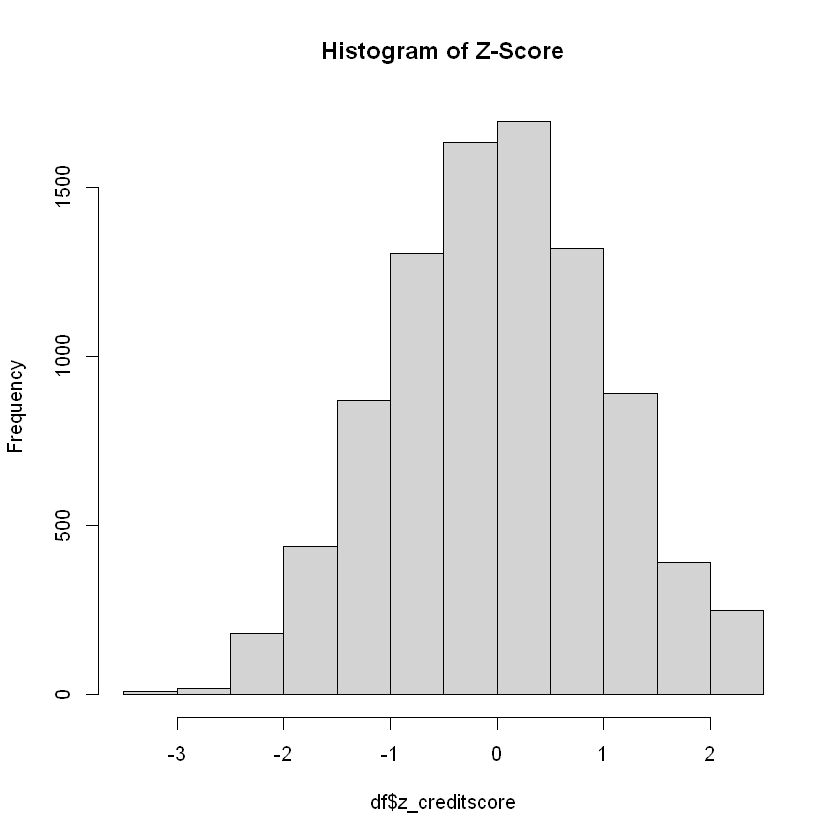

In [189]:
#boxplot.stats(df$credit_score)$out
df$z_creditscore <- scale(df$credit_score)
hist(df$z_creditscore, main = "Histogram of Z-Score")


In [407]:
z_outlier <- which(df$z_creditscore < -3)
summary(df$z_creditscore)
paste0(length(z_outlier), " outliers using the z-score filter")

       V1         
 Min.   :-3.1103  
 1st Qu.:-0.6874  
 Median : 0.0167  
 Mean   : 0.0000  
 3rd Qu.: 0.6897  
 Max.   : 2.0669  

[1] "8 outliers using the z-score filter"

The z-score method identified 8 values as outliers, but both the Rosner test and the Grubbs test did not, it's possible that the z-score method was overly sensitive to the distribution of the data. The Shapiro test suggests that the credit_score variable is not normally distributed, which may make the z-score method less reliable.

In [408]:
# Hample filter: Consider as outliers the values outside the interval formed by the median, plus or minus 3 median absolute deviations
lower_bound <- median(df$credit_score) - 3 * mad(df$credit_score, constant = 1)
upper_bound <- median(df$credit_score) + 3 * mad(df$credit_score, constant = 1)
hample_outlier <- which(df$credit_score < lower_bound | df$credit_score > upper_bound)
paste0(length(hample_outlier), " outliers using the hample filter")

[1] "183 outliers using the hample filter"

In [123]:
numeric_variables <- names(df)[sapply(df, function(col) {
  is.numeric(col) && length(unique(col)) > 11 && !grepl("CustomerId", col)
})]
paste0(numeric_variables, " is a numeric variable.")

[1] "credit_score is a numeric variable."    
[2] "age is a numeric variable."             
[3] "balance is a numeric variable."         
[4] "estimated_salary is a numeric variable."

In [427]:
# Function to perform Grubbs test on highest value of each numeric column
grubbs_test_highest <- function(df, numeric_cols) {
  out_cols <- list() # Initialize an empty list to store results
  
  # Loop through each numeric column
  for (col in numeric_cols) {
    test_res <- grubbs.test(df[[col]]) # Perform Grubbs test on column
    if (test_res$p.value < 0.05) { # Check if p-value is less than 0.05
      out_cols[[col]] <- test_res # Add result to output list
    }
  }
  
  return(out_cols) # Return output list
}

# Function to perform Grubbs test on lowest value of each numeric column
grubbs_test_lowest <- function(df, numeric_cols) {
  out_cols <- list() # Initialize an empty list to store results
  
  # Loop through each numeric column
  for (col in numeric_cols) {
    test_res <- grubbs.test(df[[col]], opposite = TRUE) # Perform Grubbs test on column with opposite direction
    if (test_res$p.value < 0.05) { # Check if p-value is less than 0.05
      out_cols[[col]] <- test_res # Add result to output list
    }
  }
  
  return(out_cols) # Return output list
}

In [425]:
grubbs_test_highest(df, numeric_variables)

$age

	Grubbs test for one outlier

data:  df[[col]]
G = 5.07579, U = 0.99714, p-value = 0.001705
alternative hypothesis: highest value 92 is an outlier



Since the p-value is less than the significance level of 0.05, we reject the null hypothesis and conclude that there is at least one outlier in the age variable. The test suggests that the highest age value 92 is an outlier.

In [426]:
grubbs_test_lowest(df, numeric_variables)

list()

In [411]:
test <- grubbs.test(df$credit_score)
test


	Grubbs test for one outlier

data:  df$credit_score
G = 3.11029, U = 0.99892, p-value = 1
alternative hypothesis: lowest value 350 is an outlier


The p-value is very high (1), indicating that there is no evidence of an outlier in the credit_score variable. Therefore, there is no reason to remove any credit_score data points based on the Grubbs test.

In [436]:
test <- rosnerTest(df$credit_score,
  k = 10
)
test$all.stats

i,Mean.i,SD.i,Value,Obs.Num,R.i+1,lambda.i+1,Outlier
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
0,650.3868,96.57842,350,1456,3.110289,4.540157,FALSE
1,650.4202,96.53186,350,1637,3.112135,4.540134,FALSE
2,650.4535,96.48524,350,7828,3.113984,4.540110,FALSE
3,650.4869,96.43859,350,7865,3.115837,4.540086,FALSE
4,650.5203,96.39189,350,8661,3.117693,4.540063,FALSE
5,650.5538,96.34514,351,2216,3.109173,4.540039,FALSE
6,650.5871,96.29870,358,1744,3.038328,4.540015,FALSE
7,650.6196,96.25461,359,1248,3.029669,4.539992,FALSE
8,650.6520,96.21081,363,1067,2.989810,4.539968,FALSE


None of the credit_score values were flagged as outliers by the Rosner test, as all the "Outlier" values are FALSE.

In [194]:
# Define a function to calculate outlier thresholds for a variable in a dataframe
outlier_thresholds <- function(df, variable, low_quantile=0.025, up_quantile=0.975){
  # Calculate the first quartile (lower quantile) of the variable
  quantile_one <- quantile(df[[variable]], low_quantile)
  # Calculate the third quartile (upper quantile) of the variable
  quantile_three <- quantile(df[[variable]], up_quantile)
  # Calculate the interquartile range of the variable
  interquantile_range <- quantile_three - quantile_one
  # Calculate the upper limit for outliers
  up_limit <- quantile_three + 1.5 * interquantile_range
  # Calculate the lower limit for outliers
  low_limit <- quantile_one - 1.5 * interquantile_range
  # Return the lower and upper limits as a vector
  return(c(low_limit, up_limit))
}

In [204]:
# Define a function to check for outliers in numeric columns of a dataframe
has_outliers <- function(dataframe, numeric_columns) {
  
  outlier_counts <- list() 
  # Loop through each numeric column in the dataframe
  for (col in numeric_columns) {
    # Calculate the outlier limits for the column using the outlier_thresholds function
    limits <- outlier_thresholds(dataframe, col)
    low_limit <- limits[1]
    up_limit <- limits[2]
    # Check if the column has any values outside the outlier limits
    if (any(dataframe[[col]] < low_limit | dataframe[[col]] > up_limit)) {
        # If there are outliers, count them and add outlier count to list
        outlier_ind <- which(dataframe[[col]] < low_limit | dataframe[[col]] > up_limit)
        outlier_counts[[col]] <- sum(outlier_ind) 
    }
      
    else {
      outlier_counts[[col]] <- 0 
    }
  }
  return(outlier_counts)
}


In [205]:
for (var in numeric_variables) {
  outliers <- has_outliers(df, var)
  print(paste(var, "has", outliers, "outliers"))
}

[1] "credit_score has 0 outliers"
[1] "age has 0 outliers"
[1] "balance has 0 outliers"
[1] "estimated_salary has 0 outliers"


__1.2 Are there variables in the dataset that will not be used in the analysis? Remove them.__

In [160]:
# Drop customer_id column
df <- select(df, -customer_id)

__1.3 Are there categorical variables in the dataset? 
Should you convert those variables to numerical?__

In [163]:
#One-hot encoding of gender variable
gender_encoded <- model.matrix(~ gender - 1, data = df)
new_df <- cbind(df, gender_encoded)

#One-hot encoding of country variable
country_encoded <- model.matrix(~ country - 1, data = df)
new_df <- cbind(new_df, country_encoded)

#Drop redundant columns (Verify if droping genderMale and countrySpain is right?)
new_df <- select(new_df, -gender, -genderMale, -country, -countrySpain)
head(new_df)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,619,42,2,0.00,1,1,1,101348.88,1,1,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,0,0
6,822,50,7,0.00,2,1,1,10062.80,0,0,1,0


# 2: Exploratory Data Analysis

__2.1: What is the overall rate of customer churn in the dataset?__

In [164]:
churn_rate <- mean(df$churn)
churn_rate_pct <-paste0(round(churn_rate*100,2),"%")
cat("The overall rate of customer churn is:",churn_rate_pct)

The overall rate of customer churn is: 20.36%

__2.2: How does the rate of customer churn vary by demographic variables such as age, gender, etc.? How does it vary across the countries?__

In [165]:
churn_rate_by_gender <- aggregate(churn ~ gender, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
churn_rate_by_country <- aggregate(churn ~ country, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
cat("Churn rate by gender:\n")
print(churn_rate_by_gender)
cat("\n")                         
cat("Churn rate by country:\n")
print(churn_rate_by_country)

Churn rate by gender:
  gender churn
1 Female 24.98
2   Male 16.49

Churn rate by country:
  country churn
1  France 16.15
2 Germany 32.33
3   Spain 16.70


Women have, on average, a higher churn rate then men. Germans have, on average, a higher churn rate than French and Spanish.

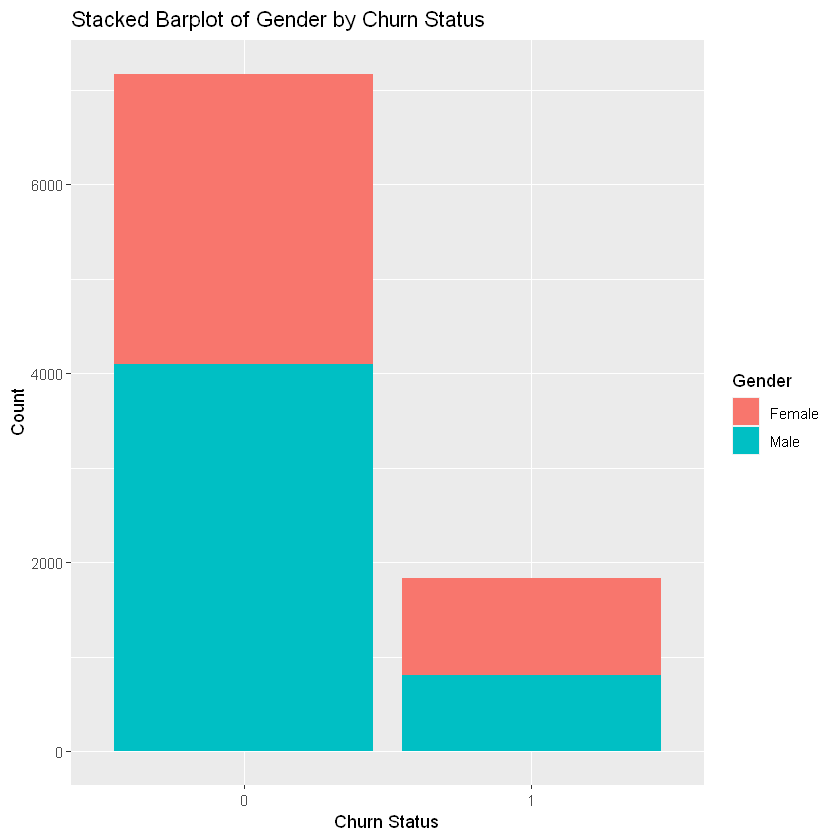

In [376]:
ggplot(data = df, aes(x = churn, fill = gender)) +
  geom_bar() +
  labs(x = "Churn Status", y = "Count", fill = "Gender") +
  ggtitle("Stacked Barplot of Gender by Churn Status")

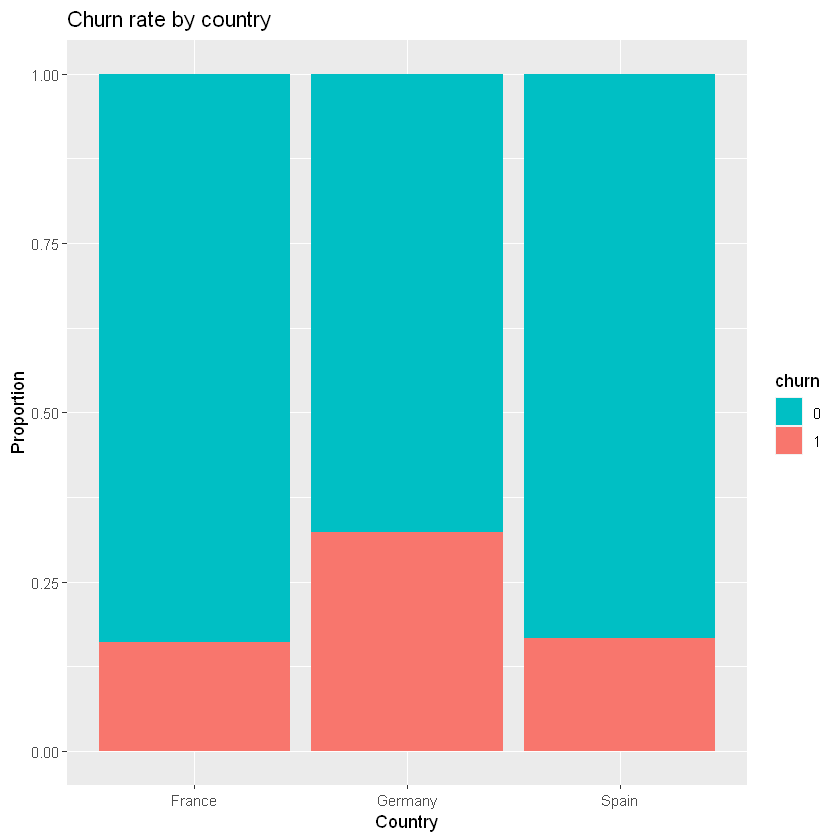

In [390]:
ggplot(data = df, aes(x = country, fill = churn)) +
  geom_bar(position = "fill") +
  labs(title = "Churn rate by country", x = "Country", y = "Proportion") +
  scale_fill_manual(values = c("#00BFC4", "#F8766D")) # optional: custom color palette

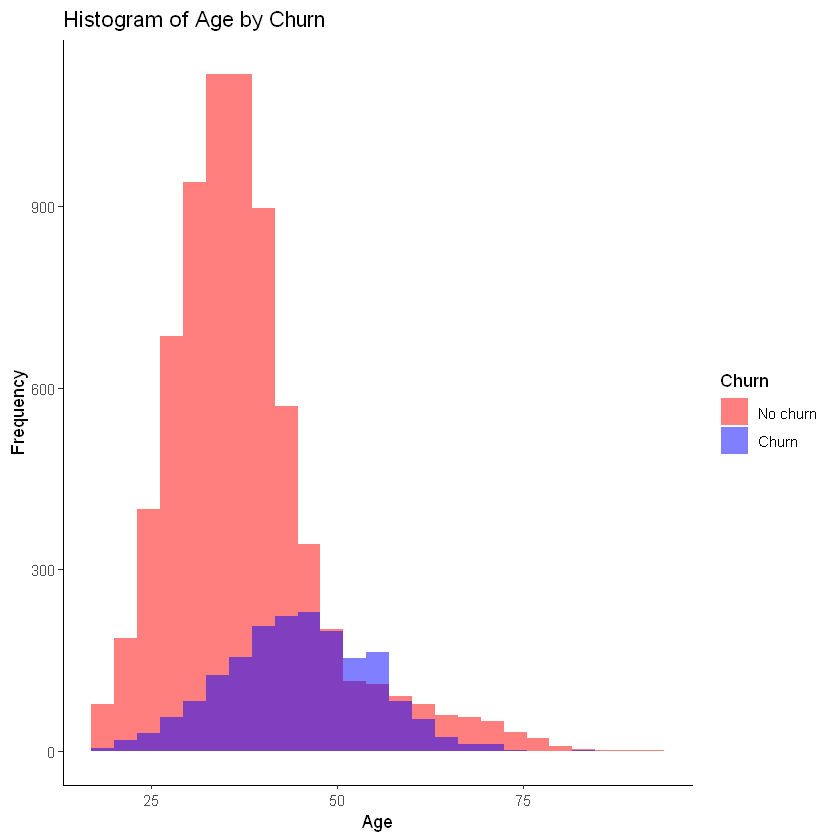

In [166]:
# Plot age distribution by churn vs. no-churn
ggplot(df, aes(x = age, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Age by Churn", x = "Age", y = "Frequency", fill = "Churn") +
  theme_classic()

In [381]:
head(df)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,z_creditscore
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,"<dbl[,1]>"
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1,-0.3249875
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,-0.4388846
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.5033549
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2.0668511
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,-0.0557762
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,1.7769313


In [167]:
age_brackets <- cut(df$age, breaks = seq(15, 95, by = 5), right = FALSE)
churn_rate_by_age_bracket <- aggregate(churn ~ age_brackets, df, function(x) round(100 * sum(x) / length(x), 2))
cat("Churn rate by country:\n")
print(churn_rate_by_age_bracket)

Churn rate by country:
   age_brackets churn
1       [15,20)  6.52
2       [20,25)  9.24
3       [25,30)  6.89
4       [30,35)  8.46
5       [35,40) 12.97
6       [40,45) 24.17
7       [45,50) 42.84
8       [50,55) 56.28
9       [55,60) 54.55
10      [60,65) 41.44
11      [65,70) 21.37
12      [70,75) 15.91
13      [75,80)  0.00
14      [80,85) 11.11
15      [85,90)  0.00
16      [90,95)  0.00


Customers in the age group between 45 and 65 have the highest churn rate. 

In [373]:
head(df[,-12])

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0


__2.3: Report interesting patterns that you find in the dataset.__

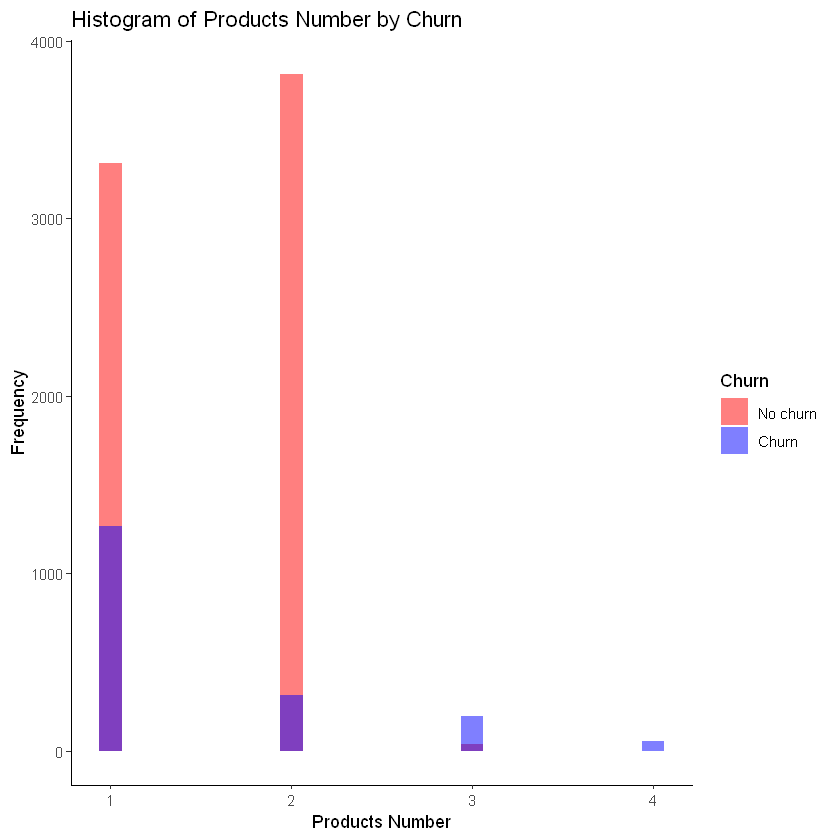

In [168]:
# Plot product number distribution by churn vs. no-churn
ggplot(df, aes(x = products_number, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Products Number by Churn", x = "Products Number", y = "Frequency", fill = "Churn") +
  theme_classic()

In [169]:
# Separate out ages for two groups
products_churn <- df$products_number[df$churn == 1]
products_no_churn <- df$products_number[df$churn == 0]

# Calculate difference in mean and median
mean_diff_products <- mean(products_no_churn) - mean(products_churn)
median_diff_products <- median(products_no_churn) - median(products_churn)
cat("Mean diff in number of products:", mean_diff_products, "\n")
cat("Median diff in number of products:", median_diff_products, "\n")

# Run t-test
ttest <- t.test(products_churn, products_no_churn)
pval <- ttest$p.value
cat("P-value for number of products vs churn:", pval, "\n")

Mean diff in number of products: 0.0712257 
Median diff in number of products: 1 
P-value for number of products vs churn: 0.0002905912 


There seems to be a statistically significant relationship between the number of products and churn. Customers that have a higher number of products are less likely to churn. The fact, however, that customers with four products have all churned goes against this observation. 

In [374]:
head(subset(df, products_number == 4))

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,z_creditscore
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,"<dbl[,1]>"
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,-2.8410774
65,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1,0.9071718
1115,628,France,Female,46,1,46870.43,4,1,0,31272.14,1,-0.2317990
1307,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1,1.7458685
1324,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1,-0.5631359
1519,792,France,Male,50,9,0.00,4,1,1,194700.81,1,1.4663029


In [171]:
# create contingency table to test relationship between churn and membership status
table_active_member <- table(df$active_member, df$churn)
rownames(table_active_member) <- c("Non-Active Member", "Active Member")
colnames(table_active_member) <- c("Not Churned", "Churned")

# run chi-squared test and print p-value
test <- chisq.test(table_active_member)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
rownames(expected) <- rownames(table_active_member)
colnames(expected) <- colnames(table_active_member)
print(expected)

[1] 1.654353e-46
                   
                    Not Churned  Churned
  Non-Active Member    3478.869 889.1307
  Active Member        3689.131 942.8693


There is a statistically significant relationship between membership status and churn. Non-active members are more likely to churn than active members. 

__2.4: Further non-significant findings:__

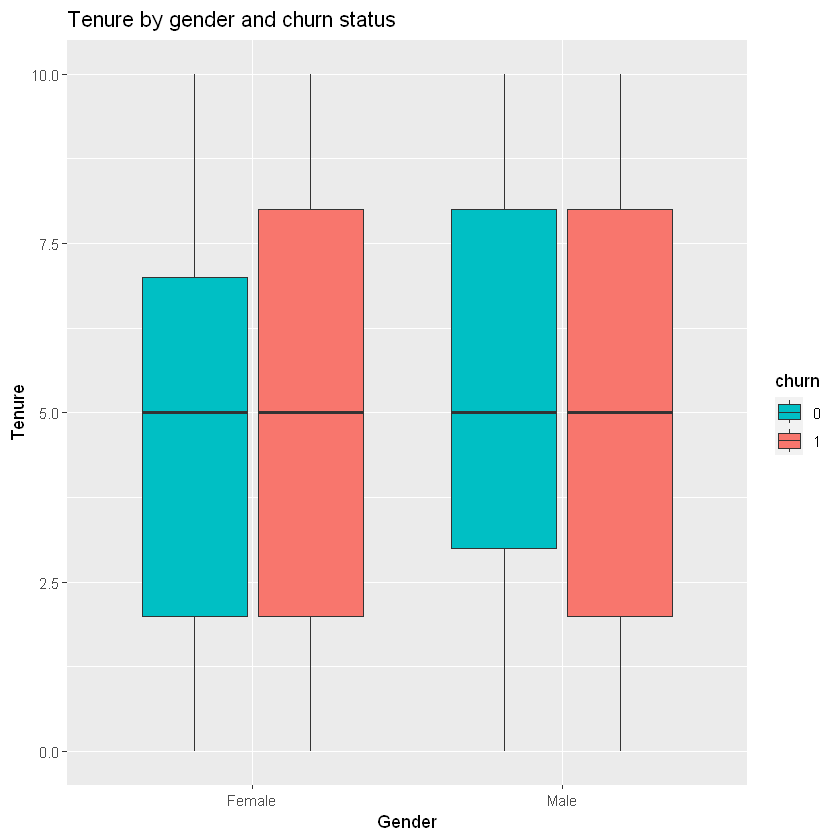

In [392]:
ggplot(data = df, aes(x = gender, y = tenure, fill = churn)) +
  geom_boxplot() +
  labs(title = "Tenure by gender and churn status", x = "Gender", y = "Tenure") +
  scale_fill_manual(values = c("#00BFC4", "#F8766D")) # optional: custom color palette

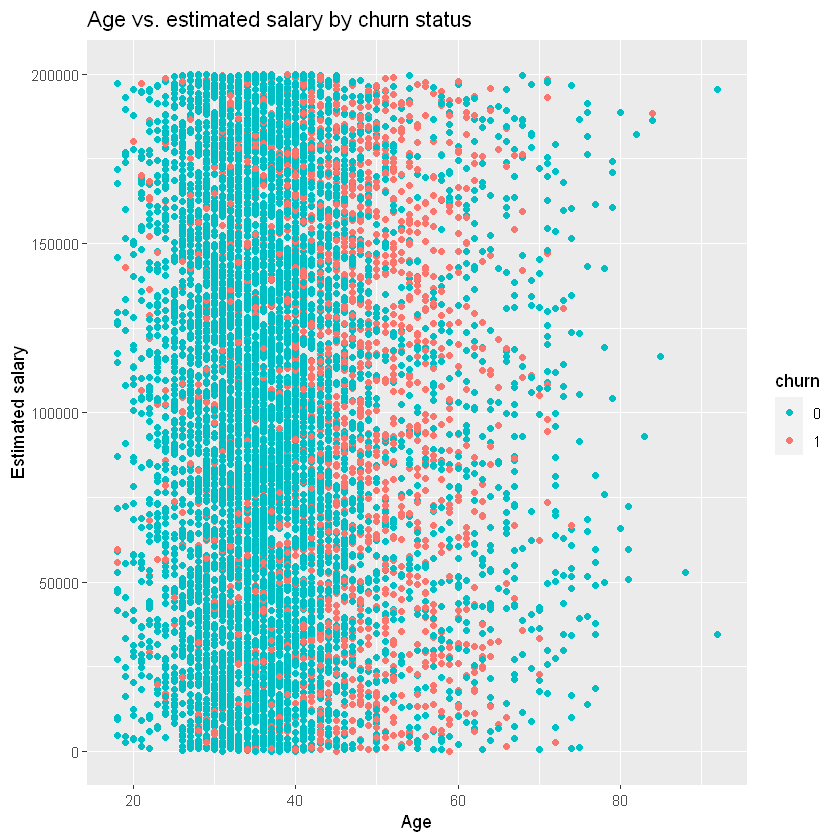

In [391]:
ggplot(data = df, aes(x = age, y = estimated_salary, color = churn)) +
  geom_point() +
  labs(title = "Age vs. estimated salary by churn status", x = "Age", y = "Estimated salary") +
  scale_color_manual(values = c("#00BFC4", "#F8766D")) # optional: custom color palette

In [172]:
# create contingency table to test relationship between churn and credit card ownership
table_credit_card <- table(df$credit_card, df$churn)

# run chi-squared test and print p-value
test <- chisq.test(table_credit_card)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
print(expected)

[1] 0.5254901
   
          0       1
  0 2114.56  540.44
  1 5053.44 1291.56


No statistically significant relationship between churn rate and credit card ownership as p-value is not leas than the significance level of 5%

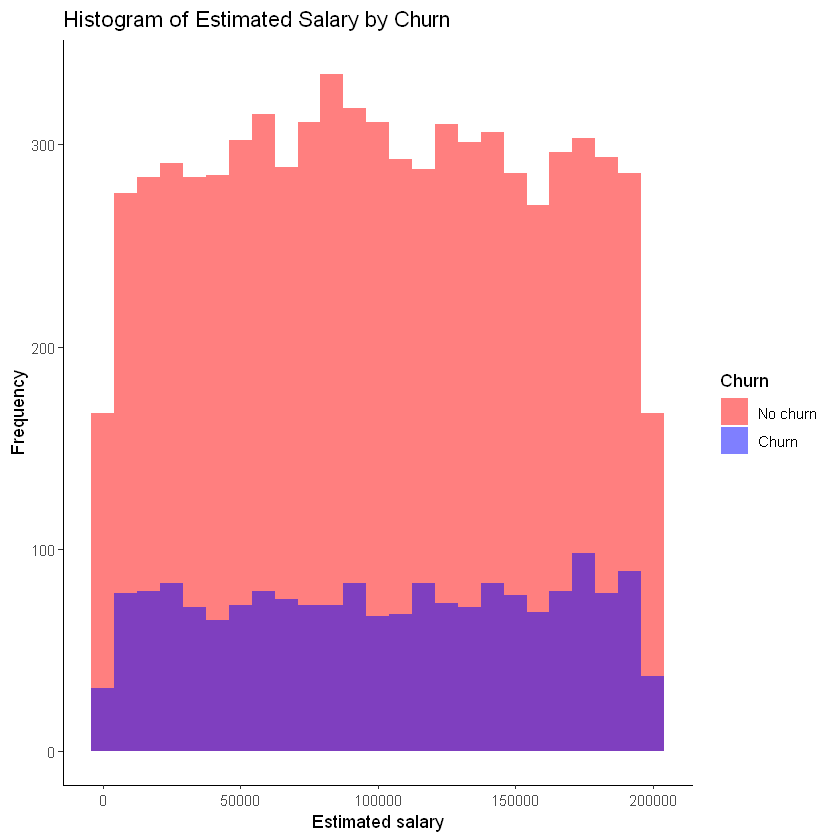

In [173]:
# Plot estimated salary distribution by churn vs. no-churn
ggplot(df, aes(x = estimated_salary, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Estimated Salary by Churn", x = "Estimated salary", y = "Frequency", fill = "Churn") +
  theme_classic()

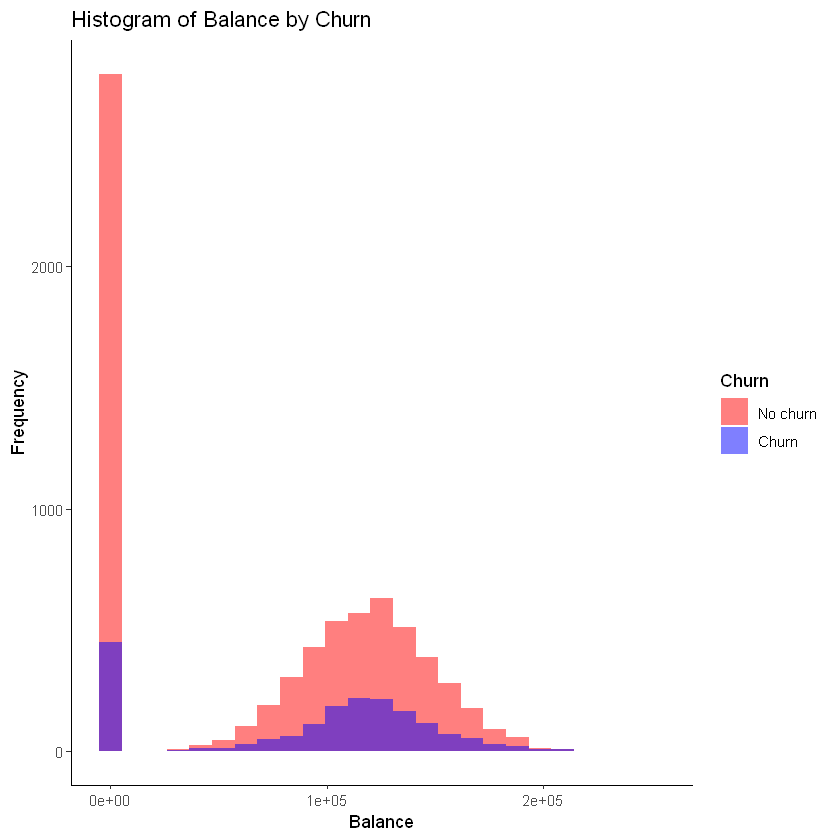

In [174]:
# Plot balance distribution by churn vs. no-churn
ggplot(df, aes(x = balance, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Balance by Churn", x = "Balance", y = "Frequency", fill = "Churn") +
  theme_classic()

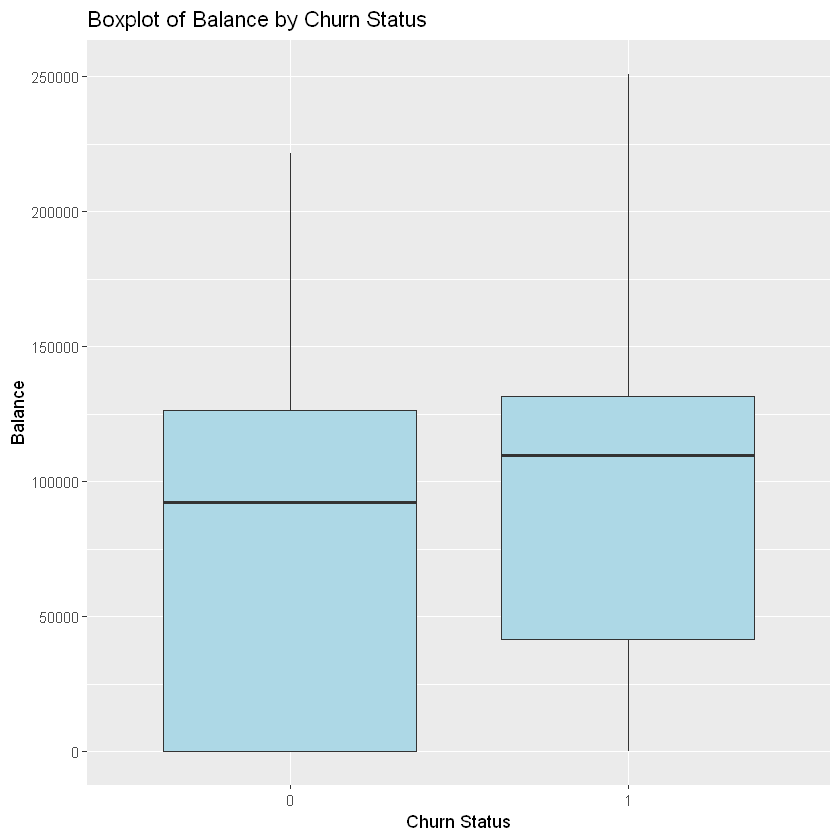

In [379]:
ggplot(data = df, aes(x = churn, y = balance)) +
  geom_boxplot(fill = "lightblue") +
  labs(x = "Churn Status", y = "Balance") +
  ggtitle("Boxplot of Balance by Churn Status")

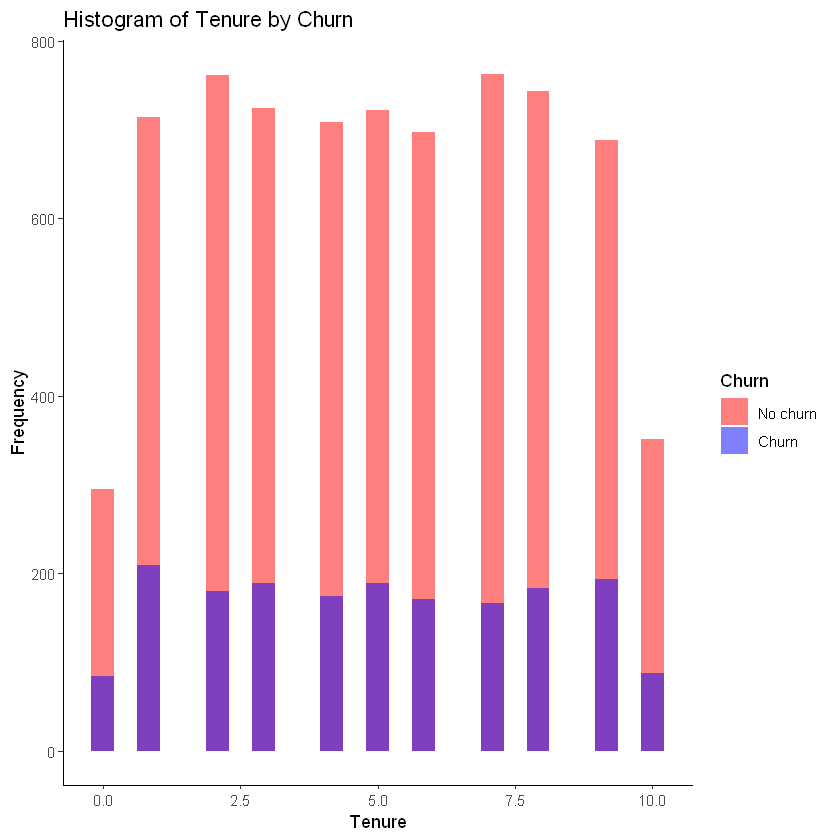

In [175]:
# Plot tenure distribution by churn vs. no-churn
ggplot(df, aes(x = tenure, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Tenure by Churn", x = "Tenure", y = "Frequency", fill = "Churn") +
  theme_classic()

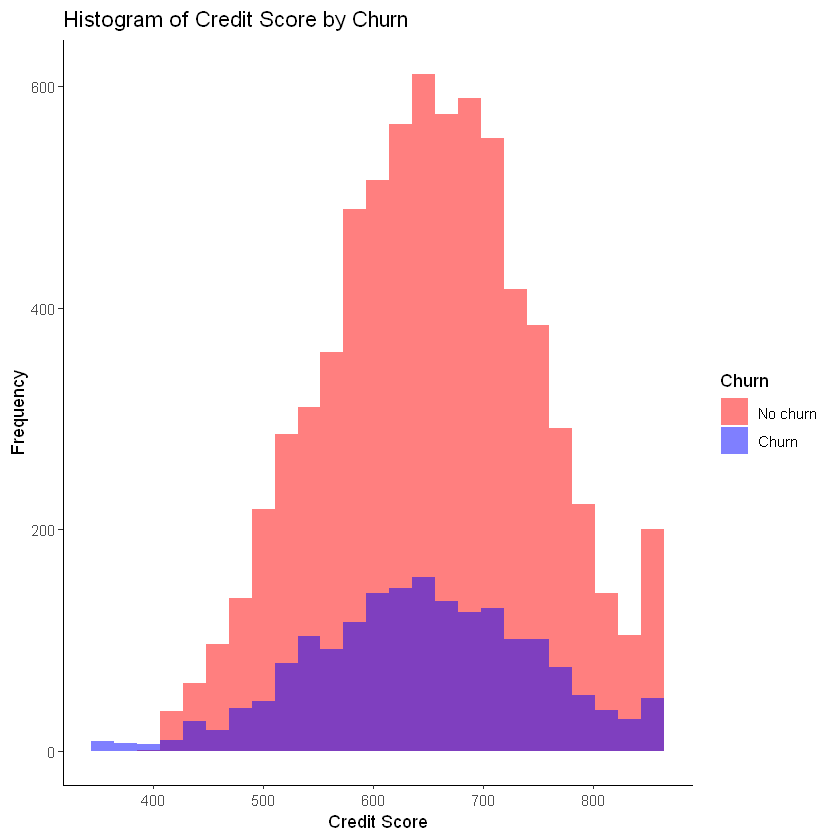

In [176]:
# Plot credit score distribution by churn vs. no-churn
ggplot(df, aes(x = credit_score, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Credit Score by Churn", x = "Credit Score", y = "Frequency", fill = "Churn") +
  theme_classic()

# 3: Model Building

Which variables are the strongest predictors of customer churn? 
How did you conclude that these are the strongest predictors? 
How do different model evaluation metrics (e.g., accuracy, precision, recall) vary for different models? 
Which model would you use for predicting customer churn?

#### 3.1 Logistic regression

In [295]:
# Load and preprocess data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)
head(churn_data)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,619,42,2,0.00,1,1,1,101348.88,1,1,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,0,0
6,822,50,7,0.00,2,1,1,10062.80,0,0,1,0


In [296]:
# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = .7, list = FALSE)
train <- churn_data[trainIndex,]
test <- churn_data[-trainIndex,]

# Fit logistic regression model
logistic_model <- glm(churn ~ ., data = train, family = binomial(link = 'logit'))

# Get summary of model coefficients
summary(logistic_model)


Call:
glm(formula = churn ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2760  -0.6585  -0.4573  -0.2691   2.9955  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.711e+00  3.107e-01 -11.945  < 2e-16 ***
credit_score     -1.010e-03  3.521e-04  -2.869 0.004122 ** 
age               7.249e-02  3.246e-03  22.332  < 2e-16 ***
tenure           -3.634e-03  1.171e-02  -0.310 0.756311    
balance           2.474e-06  6.458e-07   3.831 0.000128 ***
products_number  -9.627e-02  5.981e-02  -1.610 0.107494    
credit_card      -7.741e-02  7.425e-02  -1.043 0.297111    
active_member    -1.057e+00  7.250e-02 -14.576  < 2e-16 ***
estimated_salary  7.672e-07  5.955e-07   1.288 0.197625    
genderFemale      5.486e-01  6.863e-02   7.994 1.31e-15 ***
countryFrance    -7.886e-02  8.812e-02  -0.895 0.370817    
countryGermany    7.075e-01  9.855e-02   7.179 7.02e-13 ***
---
Signif

The strongest predictors of churn are likely to be credit score, country (Germany), gender (male), age, balance, and active member status, as these have the largest absolute coefficient values and are statistically significant

In [297]:
# Calculate variable importance
var_imp <- varImp(logistic_model)
var_imp

,Overall
,<dbl>
credit_score,2.8686815
age,22.3316424
tenure,0.3103293
balance,3.8305591
products_number,1.6095605
credit_card,1.0426488
active_member,14.5760231
estimated_salary,1.2883486
genderFemale,7.9940950


+ The most important predictor variable is 'age' with a score of 22.33, indicating that it has the largest impact on predicting the customer churn.
+ The second most important predictor variable is 'active_member' with a score of 14.58, which suggests that the customers who are active members have a higher likelihood of not churning.
+ 'countryGermany' and 'genderFemale' are also strong predictors. This means that customers from Germany are less likely to churn than customers from other countries, and male customers are more likely to churn compared to female customers.
+ 'credit_score', 'balance', 'credit_card', 'products_number', and 'estimated_salary' have smaller importance scores, but they still contribute to the model's predictive power.

In [299]:
# Evaluate model performance on test set
predicted_values <- predict(logistic_model, newdata = test, type = "response")
predicted_classes <- ifelse(predicted_values > 0.5, "Yes", "No")
actual_classes <- test$churn

# Calculate evaluation metrics
confusion_matrix <- table(actual_classes, predicted_classes)
accuracy <- sum(diag(confusion_matrix))/sum(confusion_matrix)
precision <- confusion_matrix[2, 2]/sum(confusion_matrix[, 2])
recall <- confusion_matrix[2, 2]/sum(confusion_matrix[2, ])

# Print evaluation metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")


Accuracy: 0.8140052 
Precision: 0.6180905 
Recall: 0.2240437 


+ The model correctly predicted the outcome for 81.4% of the observations in the test set.
+ Out of all the predicted positive outcomes, only 61.8% of them were actually positive.
+ Out of all the actual positive outcomes, only 22.4% of them were correctly predicted as positive by the model.

#### 3.2 Random forest

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
credit_score,4.6145729,0.1385973,3.951190,291.71834
age,74.7386965,95.5478358,106.724991,511.12464
tenure,0.3201416,2.5541243,1.686582,165.53389
balance,32.8521688,30.6252831,46.957724,295.65688
products_number,84.9468510,83.7426864,102.268622,287.75135
credit_card,-1.6068547,-2.4442869,-2.654354,39.16407
active_member,44.2494523,24.1946253,48.408269,81.72820
estimated_salary,4.1930489,-1.1563335,2.783298,294.71238
genderFemale,7.4777825,5.1518655,8.849795,42.36687
countryFrance,-5.0931100,12.2211816,4.353546,30.88592


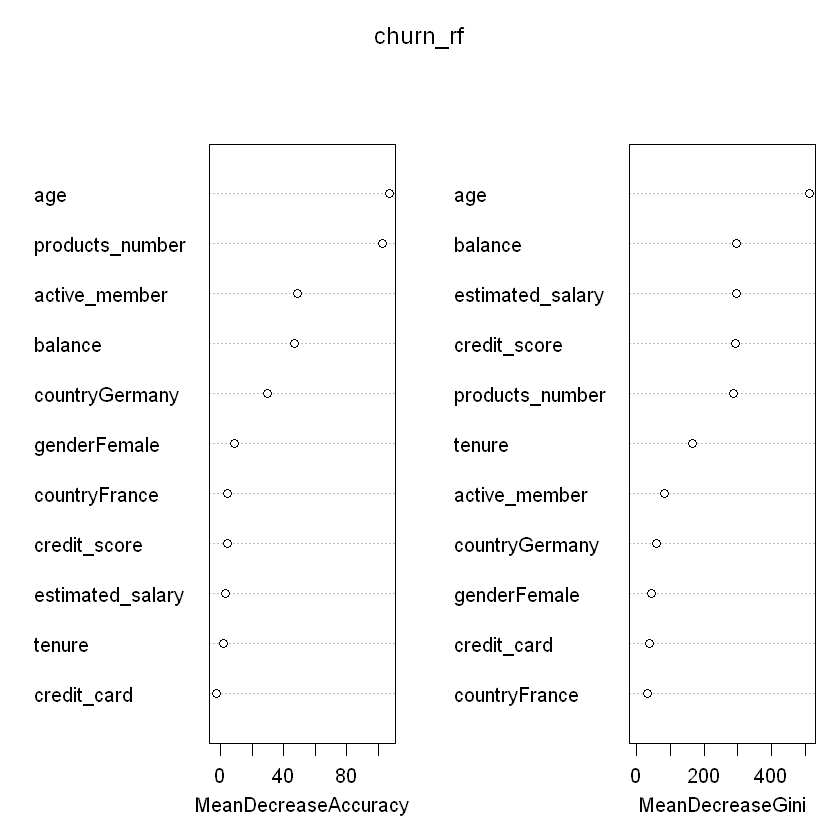

In [369]:
# Load data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)

# Split dataset
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = 0.8, list = FALSE)
train <- churn_data[trainIndex, ]
test <- churn_data[-trainIndex, ]

# Fit the random forest model
churn_rf <- randomForest(churn ~ ., data = train, importance = TRUE)

# Identify the strongest predictors of churn
varImpPlot(churn_rf)  # plot variable importance
importance(churn_rf) # return variable importance

In [368]:
# Evaluate the model performance
predicted_churn <- predict(churn_rf, newdata = test)
cm <- confusionMatrix(predicted_churn, test$churn)  # calculate confusion matrix
# Print evaluation metrics
cat("Accuracy:", cm$overall['Accuracy'], "\n")
cat("Precision:", cm$byClass['Precision'], "\n")
cat("Recall:", cm$byClass['Recall'], "\n")

Accuracy: 0.8760422 
Precision: 0.8863346 
Recall: 0.9685973 


+ 88% of the predictions by the model are correct.
+ 89% of the predicted positive cases are actually positive.
+ 97% of the actual positive cases are correctly predicted as positive.

In [370]:
# Higher the value of mean decrease accuracy or mean decrease gini score , higher the importance of the variable in the model.
# Prediction and calculating performance metrics
pred1=predict(churn_rf, type="prob")
perf = prediction(pred1[,2], churn_data$churn)

#area under curve
auc = performance(perf,"auc")
pred3 = performance(perf,"tpr","fpr")
plot(pred3, main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")

ERROR: Error in prediction(pred1[, 2], churn_data$churn): Number of predictions in each run must be equal to the number of labels for each run.


#### 3.3 Support vector machines

In [311]:
# Load the data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)

# Split the data into training and test sets
set.seed(123)
train_index <- sample(nrow(churn_data), floor(0.7 * nrow(churn_data)))
train <- churn_data[train_index, ]
test <- churn_data[-train_index, ]

# Fit the SVM model
svm_model <- svm(churn ~ ., data = train)

# Print the model summary
summary(svm_model)

# Evaluate model performance on test set
predicted_classes <- predict(svm_model, newdata = test)
actual_classes <- test$churn

# Calculate evaluation metrics
confusion_matrix <- confusionMatrix(predicted_classes, actual_classes)
accuracy <- confusion_matrix$overall['Accuracy']
precision <- confusion_matrix$byClass['Pos Pred Value']
recall <- confusion_matrix$byClass['Sensitivity']


Call:
svm(formula = churn ~ ., data = train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  2318

 ( 1072 1246 )


Number of Classes:  2 

Levels: 
 0 1




In [306]:
# Calculate variable importance
var_imp <- t(svm_model$coefs) %*% svm_model$SV
#var_imp <- data.frame(variable = colnames(train)[-ncol(train)], importance = var_imp)
var <- data.frame(var_imp[1,])
var_imp_t <- t(var_imp)
var_imp_t

credit_score,-6.2697606
age,21.1873529
tenure,-0.3803382
balance,7.4011570
products_number,5.9738582
credit_card,1.2755615
active_member,-38.7083924
estimated_salary,2.0208430
genderFemale,2.7871720
countryFrance,-1.0166098
countryGermany,4.6287953


+ The most important predictors of customer churn are age, balance, and products_number.
+ Active_member is the variable with the most negative impact on churn prediction, which means that active members are less likely to churn.
+ Credit_score and tenure have a relatively low impact on churn prediction compared to other variables.
+ Among the categorical variables, countryGermany has the highest positive impact on churn prediction, followed by genderFemale, and countryFrance has a negative impact on churn prediction.

In [312]:
# Print evaluation metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.85 
Precision: 0.8587453 
Recall: 0.9695122 


+ 85% of the predictions by the model are correct.
+ 85.7% of the predicted positive cases are actually positive.
+ 96.95% of the actual positive cases are correctly predicted as positive.

#### 3.4 Gradient boosting

In [329]:
# Load and prepare the data
churn_data <- data.frame(new_df)
train$churn <- factor(train$churn, levels = c("0", "1"))

# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = 0.8, list = FALSE)
train <- churn_data[trainIndex, ]
test <- churn_data[-trainIndex, ]

# Train XGBoost model
xgb_model <- xgboost(data = data.matrix(train[, -9]),
                     label = train$churn,
                     nrounds = 100,
                     objective = "binary:logistic",
                     verbose = 0)

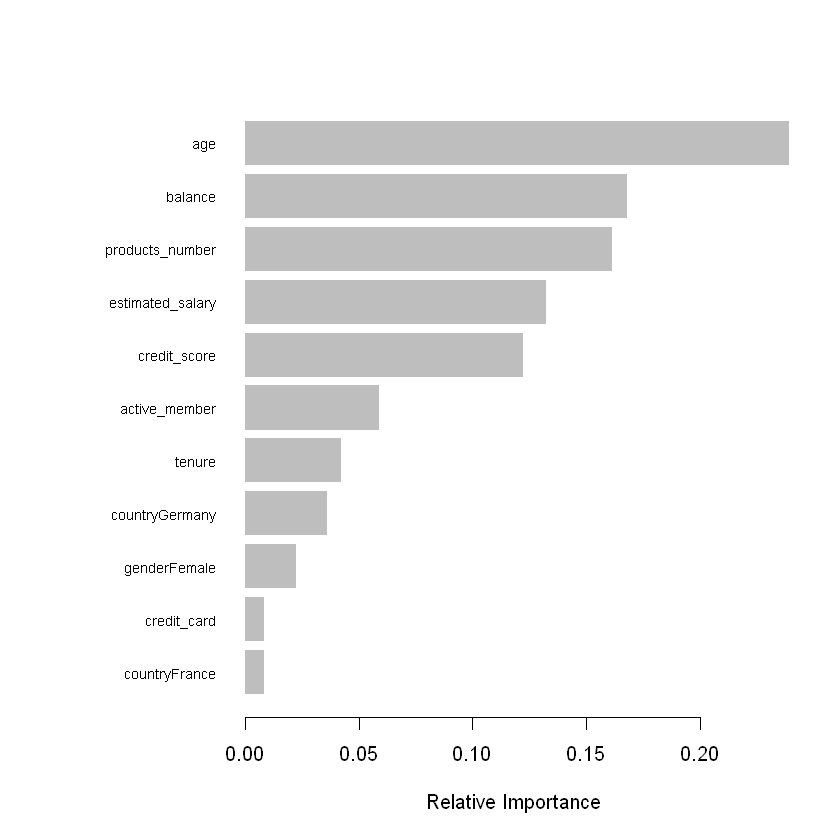

In [331]:
# Variable importance plot
importance_matrix <- xgb.importance(colnames(train[, -9]), model = xgb_model)
xgb.plot.importance(importance_matrix, xlab = "Relative Importance")

+ Age, balance and products_number are the three most important predictors

In [365]:
# you've to do your prediction here
pred <- predict(xgb_model, as.matrix(test[,c(-9,-13)]))

# and transform them in a 0 1 variable, you can choose the value to get 1
pred <-  as.numeric(pred > 0.5)

# Save confusion matrix
cm <- confusionMatrix(factor(pred),factor(churn_data[-trainIndex, ]$churn))

# Print evaluation metrics
cat("Accuracy:", cm$overall['Accuracy'], "\n")
cat("Precision:", cm$byClass['Precision'], "\n")
cat("Recall:", cm$byClass['Recall'], "\n")

Accuracy: 0.84 
Precision: 0.8692557 
Recall: 0.9398181 


+ The model has correctly predicted 84% of the outcomes.
+ Out of all the positive predictions made by the model, around 87% of them were correct.
+ Out of all the actual positive cases, the model was able to correctly identify around 94% of them.

In [ ]:
# Define the search grid
grid <- expand.grid(nrounds = c(50, 100, 150),
                    eta = c(0.01, 0.05, 0.1),
                    max_depth = c(3, 6, 9))

# Train and tune the XGBoost model
set.seed(123)
xgb_model <- train(churn ~ ., data = train, method = "xgbTree",
                   trControl = trainControl(method = "cv", number = 5, verboseIter = TRUE),
                   tuneGrid = grid)

# Print the results
print(xgb_model)

# Make predictions on the testing set
test$predicted_churn <- predict(xgb_model, newdata = test)

# Evaluate the performance of the model
confusionMatrix(table(test$predicted_churn > 0.5, test$churn))

# 4: Recommendations

Based on your analysis, develop 3 recommendations that will help EBI to better manage customer churn. Explain the rationale behind those 3 recommendations. 

EBI has formulated a list of a subset of its current customers (see the dataset “ebi_exp_customers.csv” to answer this question) and would like to use your prediction model to take proactive measures to retain these customers. Specifically, the bank would target the customers (say, via telemarketing) who have high likelihood of churn.

Use your prediction model to predict the likelihood of churn for each customer in the dataset.

Suppose that the value of retaining a customer is €5 while the cost incurred by the bank to avoid a customer from churning is €1. How many and which customers from the dataset (“ebi_exp_customers.csv”) would you recommend the bank to target to maximize the total expected profit from this proactive targeting experiment? How would your answer change if the value of retaining a customer goes up to €10? Explain your computation

In [99]:
df_2 <- read.csv("ebi_exp_customers.csv")
head(df_2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,15575430,579,France,Female,33,1,118392.8,1,1,1,157564.75,0
2,15793890,728,France,Female,59,4,0.0,1,1,1,163365.85,1
3,15701166,660,France,Male,40,5,131754.1,2,1,1,38761.61,0
4,15624677,543,Germany,Female,37,3,122304.6,2,0,0,33998.70,0
5,15586264,572,France,Male,43,2,140432.0,1,1,0,26450.57,1
6,15600991,694,Germany,Male,31,6,109052.6,2,1,1,19448.93,1
